# Mushroom Classification Project 🍄

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images
! unzip /content/mushrooms-classification-common-genuss-images.zip

In [ ]:
! pip install lightning

## Introduction

In US alone, around 7500 yearly cases of mushrooms poisoning are reported [Source](https://www.tandfonline.com/doi/abs/10.1080/00275514.2018.1479561). According to the source, "misidentification of edible mushroom species appears to be the most common cause and may be preventable through education".

In the dataset there are 9 folders of images of most common **Northern European mushrooms genuses**. Each folder consist of from 300 to 1500 selected images of mushrooms genuses.

Our task in this notebook is to create a model that is capable of identifying these different classes.

##  Imports

In [3]:
import torch
from torch import nn
from torchvision import models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision.models import ResNet18_Weights, ResNet152_Weights
from torchvision.transforms import functional as F

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import lightning as pl
from lightning import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import os
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Basic Exploration

In [4]:
data_dir = '/content/Mushrooms'

transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [5]:
num_classes = len(dataset.classes)
print('Number of classes:', num_classes)

Number of classes: 9


In the dataset we have 9 mushroom classes. The name for each class is listed below.

In [6]:
print('Class names:', dataset.classes)

Class names: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


These are the 9 different classes of Mushroom that we have in our dataset.

Below is a very short description about the different genuses.

**Agaricus**: This genus includes the common mushroom, which is
widely cultivated and consumed around the world. It is also found in the wild and can be identified by its white cap and pink gills. Some species of Agaricus are edible, while others are poisonous.

**Amanita**: This genus includes some of the most toxic mushrooms known to man, such as the death cap and destroying angel. They are characterized by their distinctive cup-shaped volva at the base of the stem and their white spores. Some species of Amanita are edible, but they must be prepared carefully to avoid poisoning.

**Boletus**: This genus includes several edible species, such as the cep or porcini mushroom, which is highly prized for its rich flavor and meaty texture. Boletus mushrooms have a distinctive cap that is often brown or reddish-brown in color and a porous underside instead of gills.

**Cortinarius**: This genus includes many species that are difficult to identify and some that are poisonous. They are characterized by their rusty brown spores and the remnants of a veil that covers the stem when young. Some species of Cortinarius are edible, but many are not recommended for consumption.

**Entoloma**: This genus includes many species that are difficult to identify and some that are poisonous. They are characterized by their pink or lilac spores and their gills that are attached to the stem instead of running down it. Some species of Entoloma are edible, but many are not recommended for consumption.

**Hygrocybe**: This genus includes many species that are brightly colored and often found in grassy areas or mossy woods. They are characterized by their waxy caps and their gills that are usually brightly colored as well. Some species of Hygrocybe are edible, but many have not been tested for toxicity.

**Lactarius**: This genus includes many species that exude a milky substance when cut or broken. They are characterized by their gills that often have a decurrent attachment to the stem and their white spores. Some species of Lactarius are edible, but others can cause gastrointestinal distress.

**Russula**: This genus includes many species that have brightly colored caps and white spores. They are characterized by their brittle flesh and their gills that do not run down the stem. Some species of Russula are edible, but others can cause gastrointestinal distress.

**Suillus**: This genus includes several edible species, such as the slippery jack mushroom, which is often found in coniferous forests. Suillus mushrooms have a distinctive slimy cap and pores instead of gills.

[Source](https://johnbeaufoy.com/identification-guide-to-mushrooms-of-britain-and-northern-europe/)

The most edible Mushroom genuses are Agaricus, Boletus, and Suillus with some mostly cultivated of their genuses respectively being
**Agaricus bisporus**: This is the most commonly cultivated and consumed mushroom in North America and Europe. It is an edible basidiomycete mushroom that is native to grasslands in Europe and North America.
**Boletus edulis**: Also known as the cep or porcini mushroom, this is a highly prized edible mushroom that has a rich flavor and meaty texture. It is often used in soups, stews, and risottos2.
**Suillus luteus**: This is a common edible mushroom that is often found in coniferous forests. It has a slimy cap and pores instead of gills3.

[Source](https://www.nutritionadvance.com/types-of-edible-mushrooms/)

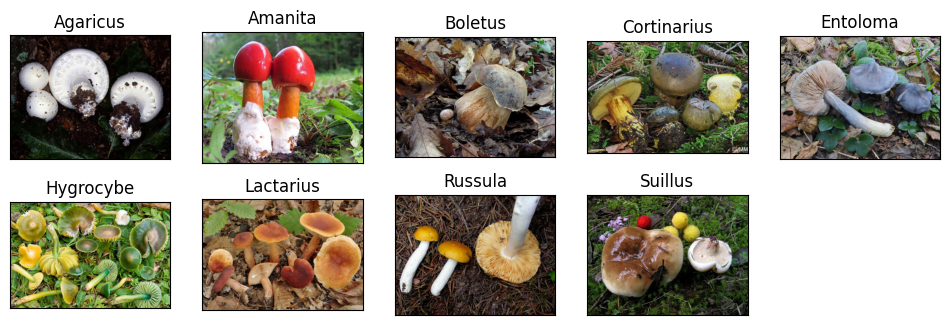

In [7]:
fig = plt.figure(figsize=(12, 14))
for i in range(num_classes):
    ax = fig.add_subplot(7, 5, i + 1, xticks=[], yticks=[])
    idx = dataset.targets.index(i)
    img = dataset[idx][0]
    ax.set_title(dataset.classes[i])
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [8]:
df = pd.DataFrame(dataset.targets, columns=['class'])
df['class_name'] = df['class'].apply(lambda x: dataset.classes[x])

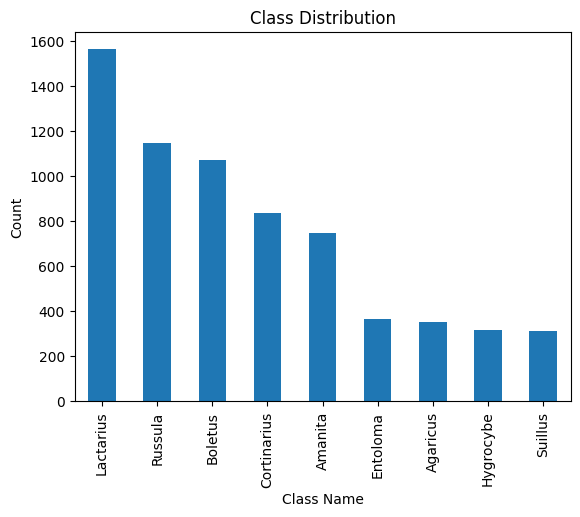

In [9]:
class_counts = df['class_name'].value_counts()

class_counts.plot(kind='bar')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

Looking at the number of data points we have for each class we notice an imbalance in the dataset.

In [ ]:
data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=0)

def mean_std(loader):
    batch_size = 64

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    mean = torch.zeros(3)
    std = torch.zeros(3)

    for batch in data_loader:
        images, _ = batch

        batch_mean = torch.mean(images, dim=(0, 2, 3))
        batch_std = torch.std(images, dim=(0, 2, 3))

        mean += batch_mean
        std += batch_std

    mean /= len(data_loader)
    std /= len(data_loader)

    return mean, std

mean, std = mean_std(data_loader)

In [ ]:
print(f'Mean: {mean}  Standard Deviation: {std}')

Mean: tensor([0.3914, 0.3697, 0.2815])  Standard Deviation: tensor([0.2499, 0.2270, 0.2237])


In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize all images to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.3914, 0.3697, 0.2815],  [0.2499, 0.2270, 0.2237])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [12]:
print(f"Number of samples: {len(dataset)}")

Number of samples: 6714


In general we have a total of 6,714 pictures in this dataset.

## Modelling

In [13]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator1)

Above we have splitted the dataset into its respective training, validation and test sets. The train set takes 70% of the data and the remaining 30% is divided among test and validation sets equally.

### Bare Modelling

In [14]:
class MushroomClassifier(pl.LightningModule):
    def __init__(self, num_classes: int):
        super().__init__()
        self.model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.outputs = []
        self.train_losses = []
        self.val_losses = []
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the last layer
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)


    def training_step(self, batch, batch_idx):
        x, y = batch
        start_time = time.time()
        logits = self(x)
        end_time = time.time()
        inference_time = end_time - start_time
        self.log('inference_time_train', inference_time, on_epoch=True, prog_bar=True, logger=True)
        loss = nn.CrossEntropyLoss()(logits, y)
        return loss

    def on_train_epoch_end(self) -> None:
        self.train_losses.append(self.trainer.callback_metrics['train_loss'].item())
        self.log('train_loss', self.train_losses[-1], on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.outputs.append({'preds': preds, 'y': y})
        return {'preds': preds, 'y': y}

    def on_test_epoch_end(self):
        preds = torch.cat([out['preds'] for out in self.outputs])
        y = torch.cat([out['y'] for out in self.outputs])
        accuracy = accuracy_score(y.cpu(), preds.cpu())
        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log('test_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_precision', precision, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_recall', recall, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_f1', f1, on_epoch=True, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        start_time = time.time()
        logits = self(x)
        end_time = time.time()
        inference_time = end_time - start_time
        self.log('inference_time', inference_time, on_epoch=True, prog_bar=True, logger=True)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self) -> None:
        self.val_losses.append(self.trainer.callback_metrics['val_loss'].item())
        self.log('val_loss', self.val_losses[-1], on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold=1e-3, min_lr=1e-5),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

This class, MushroomClassifier, is a machine learning model that classifies mushrooms into different categories. It uses a type of model called ResNet (Residual Network), which is a popular model for image classification tasks.

Here's a simple explanation of the class and its methods:

`__init__` method: This is the initializer of the class. It sets up the model with a certain number of classes and freezes all layers except the last one. Freezing a layer means that the weights of that layer will not be updated during training, which can help to prevent overfitting.

`forward` method: This is the method that defines how the model processes the input data. In this case, it simply passes the input data through the model.

`training_step` method: This method defines what happens during one step of the training process. It calculates the model's output, measures the time it took to calculate this output, and then calculates the loss of the model's predictions.

`on_train_epoch_end` method: This method is called at the end of each training epoch. It logs the training loss for that epoch.

`test_step` method: This method defines what happens during one step of the testing process. It calculates the model's output and stores the predictions and actual labels for later analysis.

`on_test_epoch_end` method: This method is called at the end of each testing epoch. It calculates several metrics (accuracy, precision, recall, F1 score) based on the model's predictions and logs these metrics.

`validation_step` method: This method is similar to training_step, but it is used during the validation process.

`on_validation_epoch_end method`: This method is called at the end of each validation epoch. It logs the validation loss for that epoch.

`configure_optimizers` method: This method sets up the optimizer and learning rate scheduler for the model. The optimizer is responsible for updating the model's weights to minimize the loss, and the learning rate scheduler adjusts the learning rate based on the validation loss.

In [ ]:
num_classes = 9
model = MushroomClassifier(num_classes)

Define the data loaders

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers = 2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers = 2)

In [17]:
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = Trainer(max_epochs=10, callbacks=[lr_monitor])

trainer.fit(model, train_loader, val_loader)

trainer.validate(model, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 58.2 M
---------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type   | Params
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      inference_time       │    0.05750880762934685    │
│        train_loss         │    0.8333589434623718     │
│         val_loss          │    0.8333589434623718     │
└───────────────────────────┴───────────────────────────┘

[{'inference_time': 0.05750880762934685,
  'train_loss': 0.8333589434623718,
  'val_loss': 0.8333589434623718}]

From our initial training we have got an inference time of 0.058 seconds.

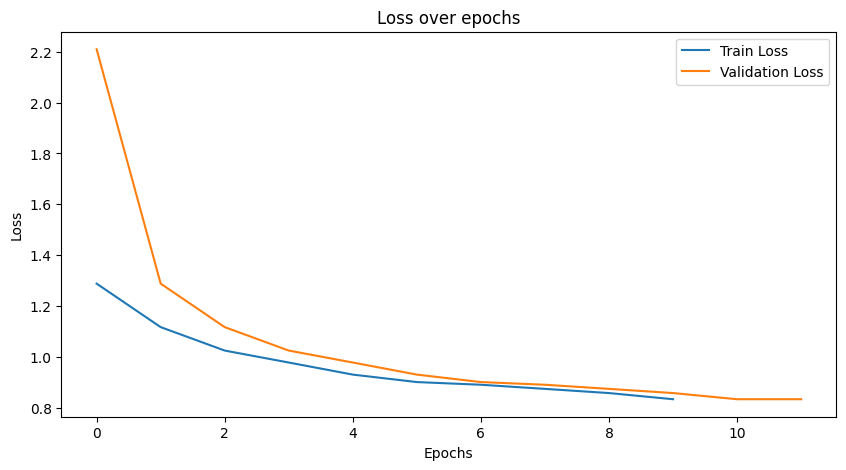

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the plot above we can see that both the validation and train losses have been reducing through successive epochs.

In [19]:
trainer.test(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7083333333333334     │
│          test_f1          │     0.690547204678357     │
│      test_precision       │    0.7027820107951448     │
│        test_recall        │    0.6819694439448903     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.7083333333333334,
  'test_precision': 0.7027820107951448,
  'test_recall': 0.6819694439448903,
  'test_f1': 0.690547204678357}]

We have got a **F1 Score** of 0.69 │ **Recall Score** of 0.68 which can be improved.

In [20]:
def get_all_logs(log_dir):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    tags = event_acc.Tags()['scalars']

    logs = {}
    for tag in tags:
        logs[tag] = [s.value for s in event_acc.Scalars(tag)]

    return logs

In [21]:
log_dir = './lightning_logs/version_0'
all = get_all_logs(log_dir)

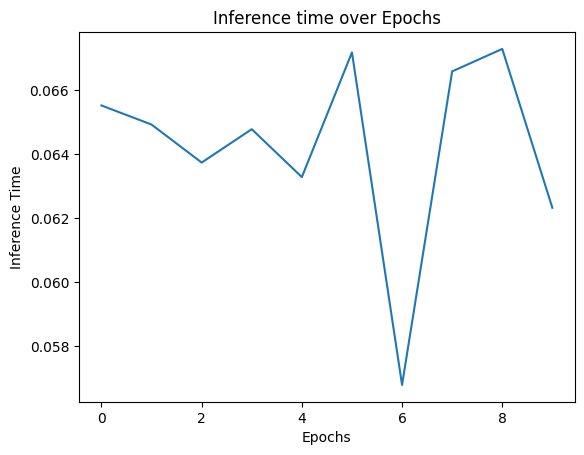

In [24]:
lr_values = all['inference_time_train_epoch']
plt.plot(lr_values)
plt.xlabel('Epochs')
plt.ylabel('Inference Time')
plt.title('Inference time over Epochs')
plt.show()

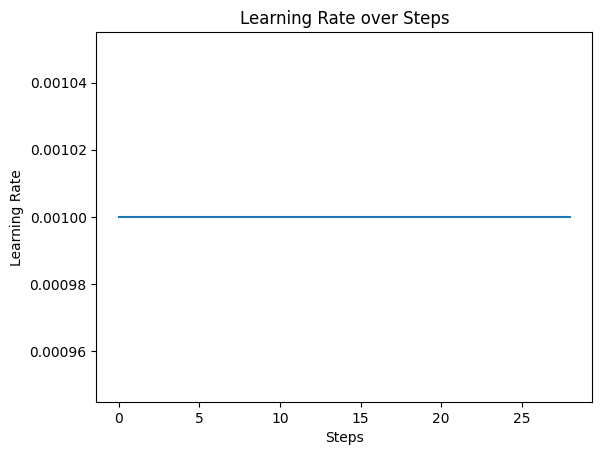

In [25]:
lr_values = all['lr-Adam']
plt.plot(lr_values)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.show()

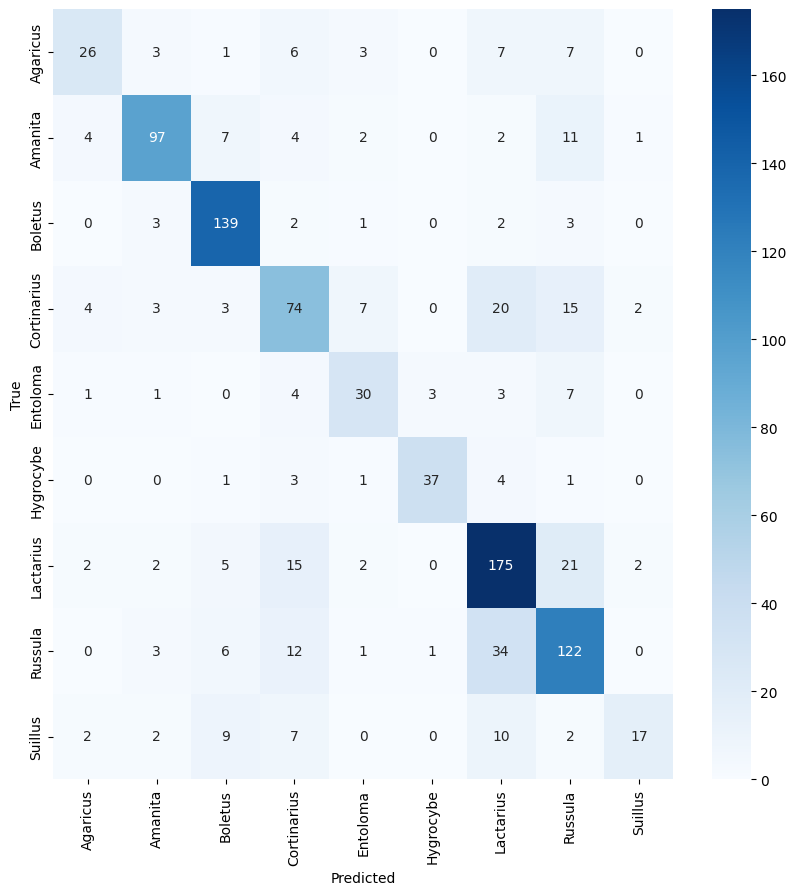

In [26]:
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to()
        labels = labels.to()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.append(labels.cpu().numpy())
        pred_labels.append(preds.cpu().numpy())

true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)

class_names = dataset.classes

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Looks like the previous model mostly confuses between.
Cortinarius <> Lactarius and Lactarius <> Rusulla which are not minority classes.

### With class weights

The new implementation of the class MushroomClassifierI introduces a new parameter `class_weights` in the `__init__` method. This parameter is used to assign different weights to different classes when calculating the loss during training.

In [27]:
class MushroomClassifierI(pl.LightningModule):
    def __init__(self, num_classes: int, class_weights):
        super().__init__()
        self.model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.class_weights = class_weights
        self.outputs = []
        self.train_losses = []
        self.val_losses = []
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the last layer
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)


    def training_step(self, batch, batch_idx):
        x, y = batch
        start_time = time.time()
        logits = self(x)
        end_time = time.time()
        inference_time = end_time - start_time
        self.log('inference_time_train', inference_time, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        loss = nn.CrossEntropyLoss(weight=self.class_weights)(logits, y)
        return loss


    def on_train_epoch_end(self) -> None:
        self.train_losses.append(self.trainer.callback_metrics['train_loss'].item())
        self.log('train_loss', self.train_losses[-1], on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.outputs.append({'preds': preds, 'y': y})
        return {'preds': preds, 'y': y}

    def on_test_epoch_end(self):
        preds = torch.cat([out['preds'] for out in self.outputs])
        y = torch.cat([out['y'] for out in self.outputs])
        accuracy = accuracy_score(y.cpu(), preds.cpu())
        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log('test_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_precision', precision, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_recall', recall, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_f1', f1, on_epoch=True, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        start_time = time.time()
        logits = self(x)
        end_time = time.time()
        inference_time = end_time - start_time
        self.log('inference_time', inference_time, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        loss = nn.CrossEntropyLoss(weight=self.class_weights)(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self) -> None:
        self.val_losses.append(self.trainer.callback_metrics['val_loss'].item())
        self.log('val_loss', self.val_losses[-1], on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold=1e-3, min_lr=1e-5),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

In [28]:
class AugmentedMinorityDataset(Dataset):
    def __init__(self, original_dataset, minority_classes, num_augmentations, angle):
        self.original_dataset = original_dataset
        self.minority_classes = minority_classes
        self.num_augmentations = num_augmentations
        self.angle = angle

    def __len__(self):
        return len(self.original_dataset) + len(self.minority_classes) * self.num_augmentations

    def __getitem__(self, index):
        if index < len(self.original_dataset):
            return self.original_dataset[index]

        minority_index = (index - len(self.original_dataset)) // self.num_augmentations
        augmented_index = (index - len(self.original_dataset)) % self.num_augmentations

        original_image, original_label = self.original_dataset[minority_index]
        if original_label in self.minority_classes:
            augmented_image = self.apply_augmentation(original_image)
            return augmented_image, original_label  # Return the original label here
        else:
            return original_image, original_label  # Return the original label here


    def apply_augmentation(self, img):
        angle = random.uniform(-self.angle, self.angle)
        img = F.rotate(img, angle)
        if random.random() < 0.5:
            img = F.vflip(img)
        if random.random() < 0.5:
            img = F.hflip(img)
        return img

In [29]:
original_dataset = dataset

In [30]:
augmented_dataset = AugmentedMinorityDataset(original_dataset, [0, 1, 3, 4, 5, 8], num_augmentations=5, angle=30)
dataset = torch.utils.data.ConcatDataset([original_dataset, augmented_dataset])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
labels = []
for _, label in augmented_dataset:
    labels.append(label)

unique_labels, counts = torch.unique(torch.tensor(labels), return_counts=True)

num_classes = len(unique_labels)
print("Number of classes:", num_classes)

for label, count in zip(unique_labels, counts):
    print("Label:", label.item(), "Count:", count.item())

Number of classes: 9
Label: 0 Count: 2118
Label: 1 Count: 4500
Label: 2 Count: 6438
Label: 3 Count: 5016
Label: 4 Count: 2184
Label: 5 Count: 1896
Label: 6 Count: 9378
Label: 7 Count: 6888
Label: 8 Count: 1866


In [31]:
class_samples = [2118, 4500, 6438, 5016, 2184, 1896, 9378, 6888, 1866]
total_samples = sum(class_samples)
num_classes = 9

class_weights = [total_samples / (num_classes * x) for x in class_samples]
class_weights_tensor = torch.Tensor(class_weights).cuda()

In [32]:
class_weights_tensor

tensor([2.1133, 0.9947, 0.6952, 0.8923, 2.0495, 2.3608, 0.4773, 0.6498, 2.3987],
       device='cuda:0')

In [33]:
train_size = int(0.7 * len(augmented_dataset))
val_size = int(0.15 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size - val_size

generator2 = torch.Generator().manual_seed(42)
train_dataset2, val_dataset2, test_dataset2 = random_split(augmented_dataset, [train_size, val_size, test_size], generator=generator2)

In [34]:
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True, num_workers = 2)
test_loader2 = DataLoader(test_dataset2, batch_size=32, num_workers = 2)
val_loader2 = DataLoader(val_dataset2, batch_size=32, num_workers = 2)

In [35]:
num_classes = 9

model2 = MushroomClassifierI(num_classes, class_weights_tensor)

In [36]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer2 = Trainer(max_epochs=10, callbacks=[lr_monitor])

trainer2.fit(model2, train_loader2, val_loader2)

trainer2.validate(model2, val_loader2)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 58.2 M
---------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type   | Params
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   inference_time_epoch    │    0.04930984973907471    │
│     train_loss_epoch      │    0.8655065298080444     │
│         val_loss          │    0.8655065298080444     │
│      val_loss_epoch       │    0.8655065298080444     │
└───────────────────────────┴───────────────────────────┘

[{'inference_time_epoch': 0.04930984973907471,
  'train_loss_epoch': 0.8655065298080444,
  'val_loss_epoch': 0.8655065298080444,
  'val_loss': 0.8655065298080444}]

The inference time didn't imporve that much as compared to the previous model partly might be the cause of additional data points.

In [37]:
trainer2.test(model2, test_loader2)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6920039486673247     │
│          test_f1          │    0.6726578526832632     │
│      test_precision       │    0.6588070266387441     │
│        test_recall        │    0.7065954701595965     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.6920039486673247,
  'test_precision': 0.6588070266387441,
  'test_recall': 0.7065954701595965,
  'test_f1': 0.6726578526832632}]

Now both our recall score has increased while the f1 score hasn't improved that much.

In [38]:
torch.save(model2.state_dict(), 'mushroom_classifier_model.pth')

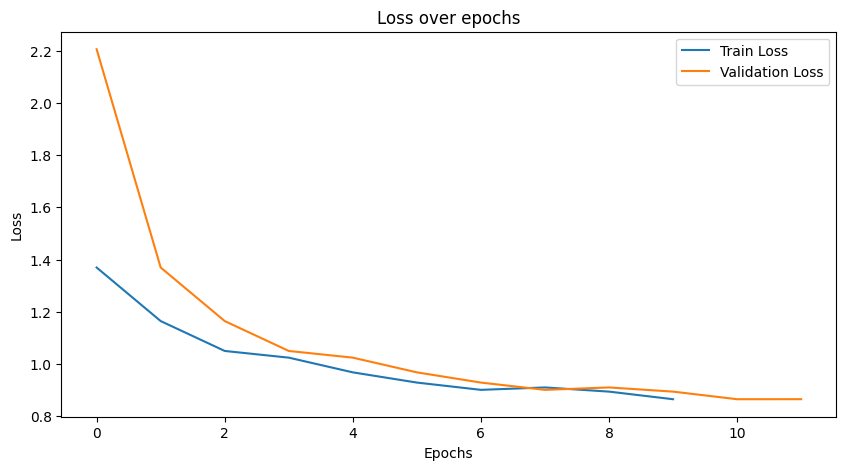

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(model2.train_losses, label='Train Loss')
plt.plot(model2.val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Our loss has bumped up around epoch 7 but has managed to decrease eventually.

In [40]:
log_dir = './lightning_logs/version_1'
all2 = get_all_logs(log_dir)

In [41]:
all.keys()

dict_keys(['lr-Adam', 'inference_time_train_step', 'epoch', 'inference_time', 'train_loss', 'val_loss', 'inference_time_train_epoch', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'])

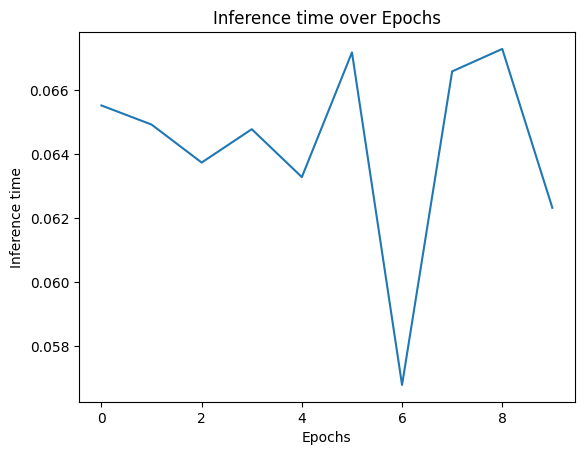

In [42]:
plt.plot(all['inference_time_train_epoch'])
plt.xlabel('Epochs')
plt.ylabel('Inference time')
plt.title('Inference time over Epochs')
plt.show()

The inference time looks more synonymous to the previous one.

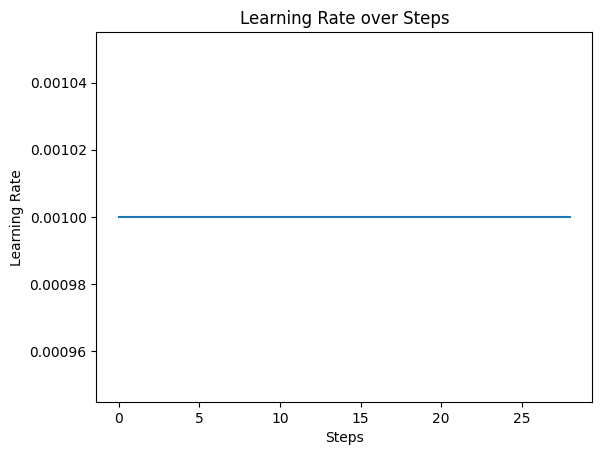

In [43]:
plt.plot(all['lr-Adam'])
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.show()

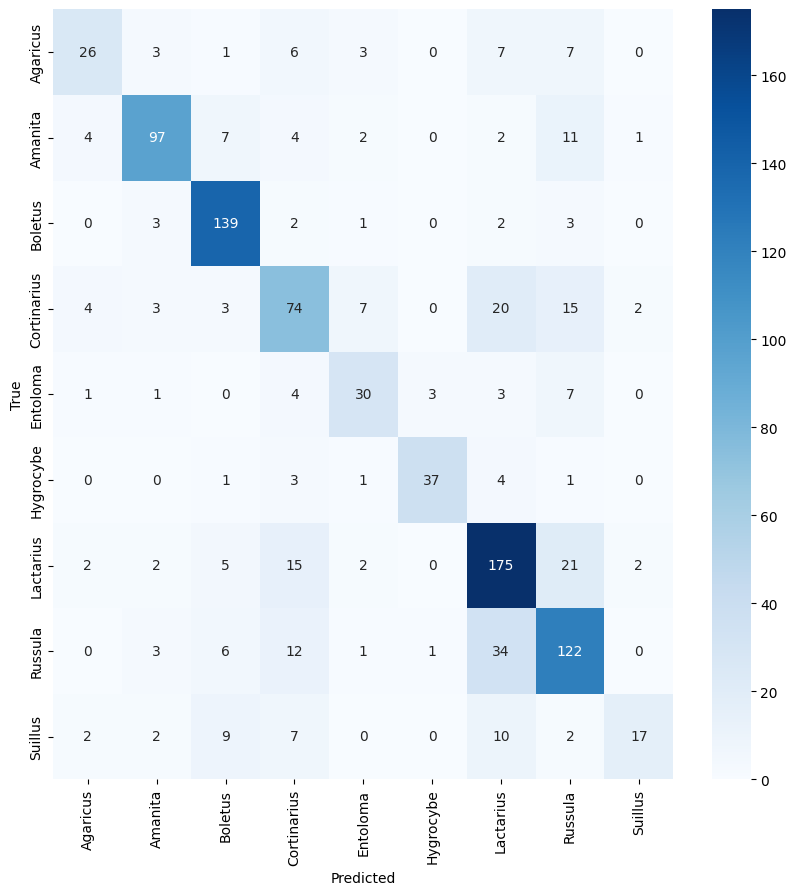

In [44]:
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to()
        labels = labels.to()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.append(labels.cpu().numpy())
        pred_labels.append(preds.cpu().numpy())

true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)

classes = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Still the previous confusion continue here as well.

## Conclusion

In this project, we aimed to create a mushroom classification model using a dataset of Northern European mushroom images to prevent misidentifications and potential poisonings. Our initial model, based on ResNet, showed promise but required improvements in accuracy and class balance.

To enhance performance, we introduced class weights to address class imbalance and applied data augmentation, particularly to underrepresented classes. This led to significant improvements in recall and F1 score.

This project can still be improved to have better performances.